In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor  # Import Random Forest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")
# Set plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.titlesize"] = 16

from Fetch_Yield import get_yield_data

The key is: 088D5072-1953-3D8C-91E3-62A84E0C49C4


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/22 21:17:49 WARN Utils: Your hostname, glory, resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlp1s0)
25/09/22 21:17:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/22 21:17:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
def Get_yield_data(States):
    Yield_data = []

    for st in States:
        Yield_data.append(pd.DataFrame(get_yield_data(st))[["year", "state_name", "county_name", "Value", "reference_period_desc"]])
    Yield_data = pd.concat(Yield_data)

    Yield_data = Yield_data[Yield_data["reference_period_desc"]=="YEAR"]
    Yield_data["state_name"] = Yield_data["state_name"].str.capitalize()
    Yield_data["county_name"] = Yield_data["county_name"].str.capitalize()

    Yield_data = Yield_data.rename(columns={"state_name": "State", "county_name": "County",
                                           "year": "Year"})
    
    return Yield_data

In [3]:
def prepare_data_weekly_agg():
    
    df = pd.read_parquet("./data/hist_wx_df.parquet", columns=["date", "adm2_name", "adm1_name", "tmax", "tmin", "precip", "swvl1", "swvl2"])
    df = df.rename(columns={"date": "Date", "adm1_name": "State", "adm2_name": "County"})
    start_month = 4
    end_month = 11
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    # --- Find max date ---
    max_date = df["Date"].max()
    max_year = df["Date"].dt.year.max()  # scalar integer

    # --- Get states and counties present on max date ---
    latest_states_counties = df[df["Date"] == max_date][["State", "County"]].drop_duplicates()

    full_dates = pd.date_range(start=max_date + pd.Timedelta(days=1),
                               end=pd.Timestamp(year=max_year, month=12, day=31))
    
    DF = []
    for date in full_dates:
        temp_df = latest_states_counties.reset_index(drop=True)
        temp_df['Date'] = date
        DF.append(temp_df)
    DF = pd.concat(DF).reset_index(drop=True)

    DF['Month'] = DF['Date'].dt.month
    DF['Day'] = DF['Date'].dt.day

    # --- Merge average values by State, County, Month, Day ---
    # Compute averages
    avg_df = df.groupby(['State','County','Month','Day'], as_index=False)[
        ['tmax','tmin','precip','swvl1','swvl2']
    ].mean()

    # Merge averages into DF
    DF = DF.merge(avg_df, on=['State','County','Month','Day'], how='inner')
    
    df = pd.concat([df, DF[["Date", "State", "County", "tmax", "tmin", "precip", "swvl1", "swvl2"]]])[["Date", "State", "County", "tmax", "tmin", "precip", "swvl1", "swvl2"]]
    
    # Convert 'Date' to datetime and filter by month
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[
        (df["Date"].dt.month >= start_month) & (df["Date"].dt.month <= end_month)
        ].copy()
    
    tmax_capped = np.minimum(df["tmax"].to_numpy(), 30)
    t_avg = (tmax_capped + df["tmin"].to_numpy()) / 2
    df = df.assign(
        GDD=np.maximum(0, t_avg - 10),
        #Heat_Stress=(df["tmax"].to_numpy() > 32).astype("int8"),  # smaller dtype
    )
    df = df.sort_values('Date')
    df['RP7'] = df['precip'].rolling(7).sum()
    df['RP30'] = df['precip'].rolling(30).sum()
    df['RP7S'] = df['RP7']**2
    df['SWVLA'] = 0.5*(df['swvl1']+df['swvl2'])
    # Extract Week and Year
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Year"] = df["Date"].dt.year

    df["Week"] = df["Week"] - df.groupby("Year")["Week"].transform("min") + 1

    # Second aggregation: weekly averages
    df = df.groupby(["Year", "State", "County", "Week"], as_index=False).mean(numeric_only = True)

    # Filter to get 31 weeks for each year
    df["total_weeks_in_year"] = df.groupby("Year")["Week"].transform("nunique")
    df["max_week_per_year"] = df.groupby("Year")["Week"].transform(
        "max"
    )  # Get the max week for adjustment

    df = df[
        (df["total_weeks_in_year"] == 31)
        | (df["Week"] > (df["max_week_per_year"] - 31))
        ].copy()

    # Conditionally subtract 1 from the Week column if min week is 2
    df.loc[df.groupby("Year")["Week"].transform("min") == 2, "Week"] = (
            df.loc[df.groupby("Year")["Week"].transform("min") == 2, "Week"] - 1
    )

    df.drop(
        columns=["total_weeks_in_year", "max_week_per_year"], inplace=True
    )  # Drop temp columns


    # Re-number weeks from 1 to 31 after filtering
    df["Week"] = df.groupby(["Year", "State", "County"])["Week"].transform(
        lambda x: pd.Series(range(1, len(x) + 1), index=x.index)
    )

    df = (df.melt(
            id_vars=["State", "County", "Year", "Week"],
            var_name="Type",
            value_name="Value"
        )
        .assign(Feature_Week=lambda d: d["Type"] + "_W" + d["Week"].astype(str))
        .pivot_table(
            index=["State", "County", "Year"],
            columns="Feature_Week",
            values="Value",
            aggfunc="mean"
        )
        .reset_index()
    )

    df.columns.name = None
    
    return df

In [4]:
def prepare_data_monthly_agg():   
    # Load weather data with only required columns
    wx_hist_df = pd.read_parquet(
        "./data/hist_wx_df.parquet",
        columns=["date", "adm2_name", "adm1_name", "tmax", "tmin", "precip", "swvl1", "swvl2"]
    )

    # Rename columns in-place
    wx_hist_df.rename(
        columns={"date": "Date", "adm2_name": "County", "adm1_name": "State"},
        inplace=True
    )

    # Constants
    GROWING_SEASON_START_MONTH = 4
    GROWING_SEASON_END_MONTH = 11
    
    wx_hist_df = wx_hist_df.sort_values('Date')
    wx_hist_df['RP7'] = wx_hist_df['precip'].rolling(7).sum()
    wx_hist_df['RP30'] = wx_hist_df['precip'].rolling(30).sum()
    wx_hist_df['RP7S'] = wx_hist_df['RP7']**2
    wx_hist_df['SWVLA'] = 0.5*(wx_hist_df['swvl1']+wx_hist_df['swvl2'])

    # Filter only growing season data
    wx_gs_df = wx_hist_df.loc[wx_hist_df["Date"].dt.month.between(GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH)]

    # Calculate features directly
    tmax_capped = np.minimum(wx_gs_df["tmax"].to_numpy(), 30)
    t_avg = (tmax_capped + wx_gs_df["tmin"].to_numpy()) / 2
    wx_gs_df = wx_gs_df.assign(
        GDD=np.maximum(0, t_avg - 10),
        Heat_Stress=(wx_gs_df["tmax"].to_numpy() > 32).astype("int8"),  # smaller dtype
        Year=wx_gs_df["Date"].dt.year,
        Month=wx_gs_df["Date"].dt.month
    )

    # Aggregate at county level
    wx_gs_df = (
        wx_gs_df.groupby(["State", "County", "Year", "Month"], observed=True)
        .agg({"tmax":"mean", "tmin":"mean", "precip":"mean", "swvl1":"mean", "swvl2":"mean", "GDD":"mean"})
        .reset_index()
    )

    # Melt + pivot to final wide format
    modeling_df = (
        wx_gs_df.melt(
            id_vars=["State", "County", "Year", "Month"],
            var_name="Type",
            value_name="Value"
        )
        .assign(Feature_Month=lambda d: d["Type"] + "_" + d["Month"].astype(str))
        .pivot_table(
            index=["State", "County", "Year"], 
            columns="Feature_Month", 
            values="Value", 
            aggfunc="mean"  # safe aggregation
        )
        .reset_index()
    )

    modeling_df.columns.name = None
    # --- To fill NaNs with historical averages ---
    print(
        "Filling in missing 2024 monthly weather data with historical averages for 'modeling_df'..."
    )

    # Identify all columns that represent monthly features
    monthly_feature = [
        col
        for col in modeling_df.columns
        if (
            "_" in col
            and col.split("_")[0] in ["precip", "tmax", "tmin", "GDD", "swvl1", "swvl2"]
        )
    ]

    # Calculate the historical average for each feature, grouped by state
    historical_averages = (
        modeling_df[modeling_df["Year"] < 2024].groupby("State")[monthly_feature].mean()
    )

    # Iterate through each state and fill the missing 2024 values
    states_with_data = modeling_df["State"].unique()
    for state in states_with_data:
        # Get the index for the 2024 row for the current state
        idx_2024 = modeling_df[
            (modeling_df["Year"] == 2024) & (modeling_df["State"] == state)
        ].index

        if not idx_2024.empty:
            # Get the historical average for this state
            state_avg = historical_averages.loc[state]

            # Use .fillna() to replace NaN values in the 2024 row with the historical averages
            modeling_df.loc[idx_2024, monthly_feature] = modeling_df.loc[
                idx_2024, monthly_feature
            ].fillna(state_avg)

    print("Missing 2024 weather data filled successfully with historical averages.")

    return modeling_df

In [5]:

def Get_yield_data(States):
    Yield_data = []

    for st in States:
        Yield_data.append(pd.DataFrame(get_yield_data(st))[["year", "state_name", "county_name", "Value", "reference_period_desc"]])
    Yield_data = pd.concat(Yield_data)

    Yield_data = Yield_data[Yield_data["reference_period_desc"]=="YEAR"]
    Yield_data["state_name"] = Yield_data["state_name"].str.capitalize()
    Yield_data["county_name"] = Yield_data["county_name"].str.capitalize()

    Yield_data = Yield_data.rename(columns={"state_name": "State", "county_name": "County",
                                           "year": "Year"})
    
    return Yield_data

In [6]:
week_grouping = False

if week_grouping:
    modeling_df = prepare_data_weekly_agg()
    States = modeling_df['State'].unique()
    Yield_data = Get_yield_data(States)
    modeling_df = pd.merge(
        modeling_df,
        Yield_data[
            ["Year", "State", "County", "Value"]
        ],
        on=["Year", "State", "County"],
        how="inner",
    )

    modeling_df["Value"] = modeling_df["Value"].astype("float32")

    print(
        "\nEngineered Features (first 5 rows of state-level modeling data with monthly features):"
    )
else:
    modeling_df = prepare_data_monthly_agg()
    States = modeling_df['State'].unique()
    Yield_data = Get_yield_data(States)

#     Yield_data['Value'] = Yield_data['Value'].astype('float')
#     Yield_data['Year'] = Yield_data['Year'].astype('int')

#     Yield_data = Yield_data.groupby(['Year','State'])['Value'].mean().reset_index()

    modeling_df = pd.merge(
        modeling_df,
        Yield_data[
            ["Year", "State", "County", "Value"]
        ],
        on=["Year", "State", "County"],
        how="inner",
    )

    modeling_df["Value"] = modeling_df["Value"].astype("float32")

    print(
        "\nEngineered Features (first 5 rows of state-level modeling data with monthly features):"
    )



modeling_df.head()

Filling in missing 2024 monthly weather data with historical averages for 'modeling_df'...
Missing 2024 weather data filled successfully with historical averages.

Engineered Features (first 5 rows of state-level modeling data with monthly features):


,State,County,Year,GDD_10,GDD_11,GDD_4,GDD_5,GDD_6,GDD_7,GDD_8,...,tmax_9,tmin_10,tmin_11,tmin_4,tmin_5,tmin_6,tmin_7,tmin_8,tmin_9,Value
0,Illinois,Adams,2000,6.182752,0.771602,2.922105,9.959619,12.171090,13.928506,15.249474,...,26.207675,11.001681,0.663814,6.905648,14.886126,17.647866,19.992436,21.413322,15.753397,172.0
1,Illinois,Adams,2001,3.979902,2.469504,6.054431,8.625039,11.731747,15.065175,14.446682,...,23.860697,8.920982,6.972190,9.964862,14.162744,17.089541,21.286527,20.265182,14.647846,152.0
2,Illinois,Adams,2002,3.184186,0.552647,3.959936,6.361659,13.701331,15.836868,14.510468,...,26.863047,8.060722,1.459579,7.669724,11.145742,19.223882,22.056535,20.437567,16.491934,146.0
3,Illinois,Adams,2003,4.573316,0.976743,4.049002,7.282456,10.753055,15.059588,15.074183,...,23.395855,9.243336,3.587912,7.680662,12.287449,15.917351,21.002359,21.171784,13.893602,171.0
4,Illinois,Adams,2004,4.492806,1.019372,4.201168,9.914309,11.955193,13.810505,12.023360,...,25.661458,10.291035,5.077982,8.388970,15.284279,17.500415,19.522002,17.337211,15.775467,195.0


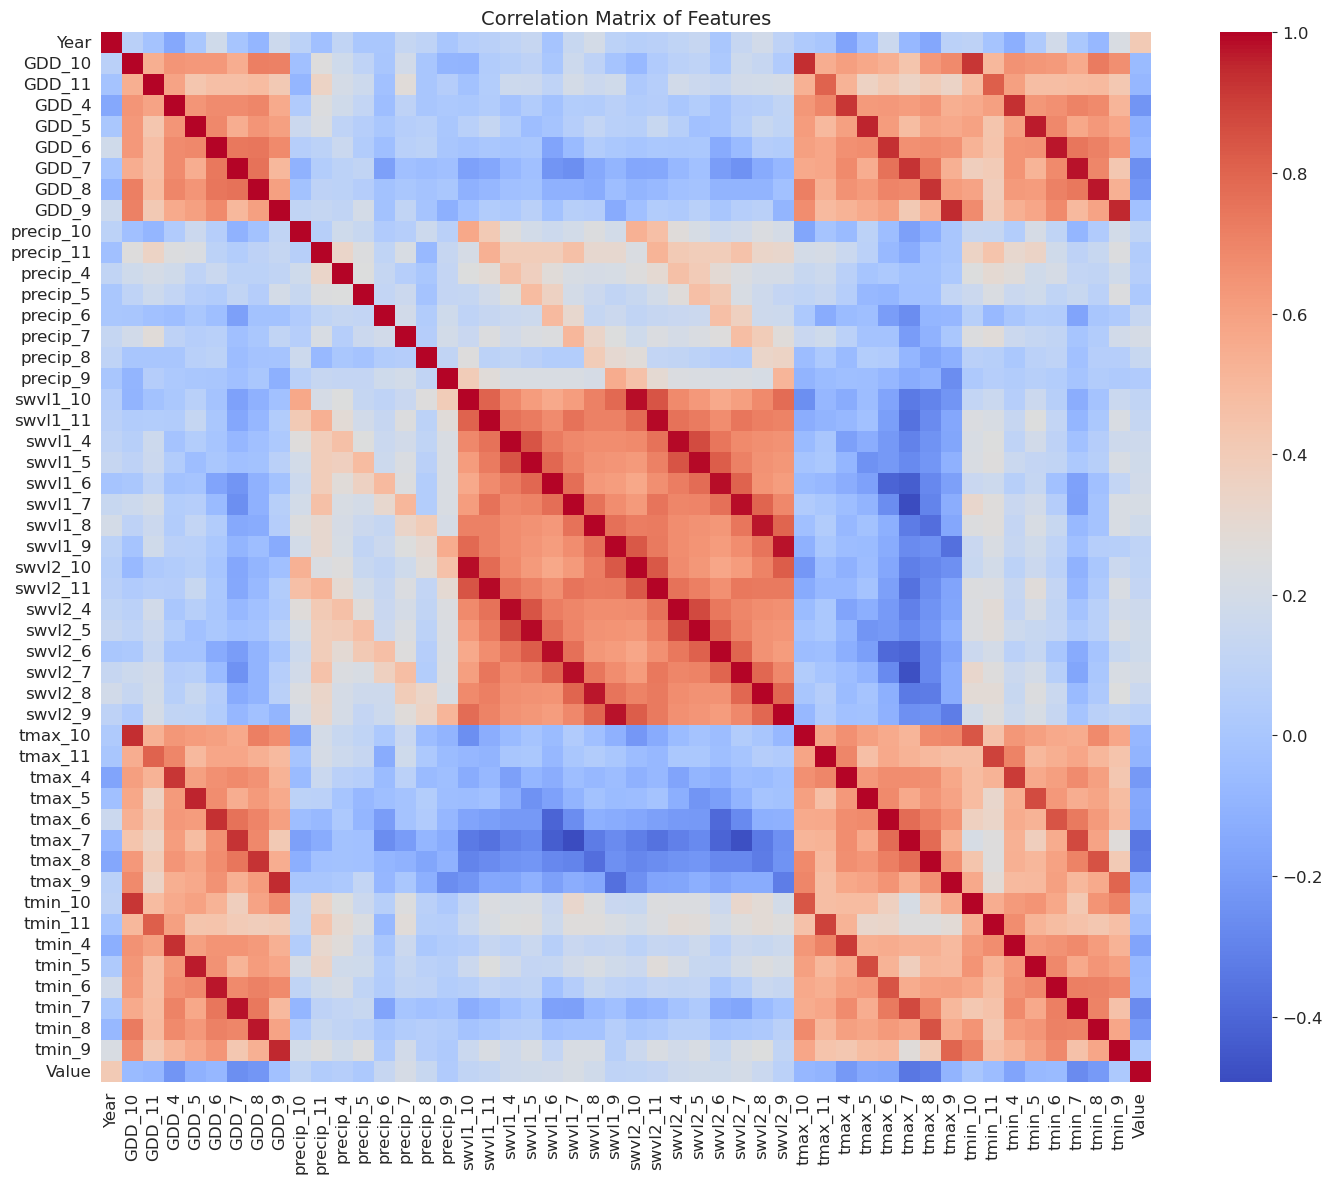

In [8]:
correlation_matrix = modeling_df.corr(numeric_only=True)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# Extract correlations with 'Yield_bu_acre'
yield_corr = correlation_matrix["Value"].drop("Value")

# Sort by absolute correlation
top_corr = yield_corr.abs().sort_values(ascending=False)

# Display top correlated features
print("Top correlated features with Yield_bu_acre:")
top_corr.head(10)  # change 10 to see more or fewer

Top correlated features with Yield_bu_acre:


Year        0.409596
tmax_7      0.344722
tmax_8      0.317871
tmin_7      0.265369
GDD_7       0.255198
GDD_4       0.235725
GDD_8       0.228639
swvl1_7     0.217147
tmax_4      0.216694
precip_7    0.211770
Name: Value, dtype: float64

In [10]:
# Define features (X) and target (y)
features = []

# Select the most correlated features to the yield
monthly_features = top_corr.index.tolist()
features.extend(monthly_features)

target = "Value"

X = modeling_df[features]
y = modeling_df[target]

train_years_end = 2023
X_train = X[X["Year"] <= train_years_end]
y_train = y[X["Year"] <= train_years_end]

X_val = X[X["Year"] > train_years_end]
y_val = y[X["Year"] > train_years_end]

print(f"Training data years: {X_train['Year'].min()} - {X_train['Year'].max()}")
print(f"Validation data years: {X_val['Year'].min()} - {X_val['Year'].max()}")
print(f"Number of training records: {len(X_train)}")
print(f"Number of validation records: {len(X_val)}")



Training data years: 2000 - 2023
Validation data years: 2024 - 2024
Number of training records: 22526
Number of validation records: 617


In [38]:
model = RandomForestRegressor(n_estimators=100,
                random_state=42, 
                n_jobs=-1)

model.fit(X_train, y_train)

print("\nModel trained successfully!")

y_pred_val = model.predict(X_val)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(
    f"\nModel Performance on Validation Set (Years {X_val['Year'].min()}-{X_val['Year'].max()}):"
)
print(f"RMSE: {rmse_val:.2f} bushels/acre")
print(f"MAE: {mae_val:.2f} bushels/acre")
print(f"R-squared: {r2_val:.2f}")


Model trained successfully!

Model Performance on Validation Set (Years 2024-2024):
RMSE: 27.21 bushels/acre
MAE: 21.16 bushels/acre
R-squared: 0.33


In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

print("\nModel trained successfully!")

y_pred_val = model.predict(X_val)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(
    f"\nModel Performance on Validation Set (Years {X_val['Year'].min()}-{X_val['Year'].max()}):"
)
print(f"RMSE: {rmse_val:.2f} bushels/acre")
print(f"MAE: {mae_val:.2f} bushels/acre")
print(f"R-squared: {r2_val:.2f}")


Model trained successfully!

Model Performance on Validation Set (Years 2024-2024):
RMSE: 29.85 bushels/acre
MAE: 23.65 bushels/acre
R-squared: 0.19


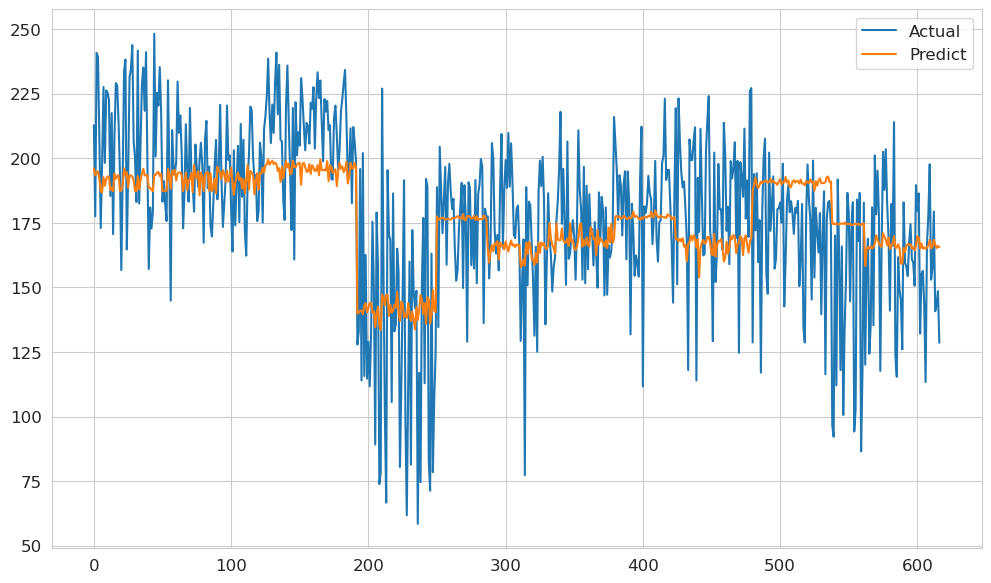

In [40]:
plt.plot(y_val.values, label = 'Actual')
plt.plot(y_pred_val, label = "Predict")
plt.legend()

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ----------------------------
# Train Model
# ----------------------------
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ----------------------------
# Evaluate
# ----------------------------
y_pred_val = model.predict(X_val_scaled)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("\nLinear Regression Performance on Validation Set:")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.2f}")
print(f"R²: {r2_val:.2f}")


Linear Regression Performance on Validation Set:
RMSE: 29.85
MAE: 23.65
R²: 0.19


In [29]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize LightGBM Regressor
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=51,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

# Train the model
model.fit(X_train, y_train)

print("\nModel trained successfully with LightGBM!")

# Predict on validation set
y_pred_val = model.predict(X_val)

# Evaluate model performance
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(
    f"\nModel Performance on Validation Set (Years {X_val['Year'].min()}-{X_val['Year'].max()}):"
)
print(f"RMSE: {rmse_val:.2f} bushels/acre")
print(f"MAE: {mae_val:.2f} bushels/acre")
print(f"R-squared: {r2_val:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12265
[LightGBM] [Info] Number of data points in the train set: 22526, number of used features: 49
[LightGBM] [Info] Start training from score 148.356885

Model trained successfully with LightGBM!

Model Performance on Validation Set (Years 2024-2024):
RMSE: 25.95 bushels/acre
MAE: 20.02 bushels/acre
R-squared: 0.39


In [46]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ----------------------------
# Scale Features
# ----------------------------
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ----------------------------
# Train Lasso Regression
# ----------------------------
lasso = Lasso(
    alpha=0.01,  # regularization strength, adjust based on validation
    max_iter=10000,
    random_state=42
)
lasso.fit(X_train_scaled, y_train)

# ----------------------------
# Evaluate
# ----------------------------
y_pred_val = lasso.predict(X_val_scaled)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("\nLasso Regression Performance on Validation Set:")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.2f}")
print(f"R²: {r2_val:.2f}")

# ----------------------------
# Optional: Feature Importance
# ----------------------------
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lasso.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\nTop features by absolute Lasso coefficient:")
print(feature_importance.head(10))



Lasso Regression Performance on Validation Set:
RMSE: 26.88
MAE: 21.16
R²: 0.35

Top features by absolute Lasso coefficient:
      Feature  Coefficient
6     tmax_W9   -95.404918
264  tmax_W27    86.716255
7    tmax_W15   -81.761445
66    GDD_W11    80.336780
278  tmin_W27   -77.160834
20    GDD_W10    76.515453
55    GDD_W12    66.549382
3    tmax_W10   -63.193738
8    tmax_W12   -62.766498
32     GDD_W9    50.428643
